In [ ]:
# Import libraries

import numpy as np
import pandas as pd
import os
from keras.preprocessing import image
from keras import preprocessing
from keras.models import load_model

# Librerias para visualizar las imágenes
%matplotlib inline
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

model_saved_dir = '/content/gdrive/MyDrive/tfm/models/vgg19/v2-02-VGG19-model'

train_dir = '/content/gdrive/MyDrive/tfm/version2/train_dir/'
test_dir = '/content/gdrive/MyDrive/tfm/version2/test_dir/'
val_dir = '/content/gdrive/MyDrive/tfm/version2/val_dir/'

Mounted at /content/gdrive


In [ ]:
%%time
model = load_model(model_saved_dir)

CPU times: user 1.9 s, sys: 659 ms, total: 2.56 s
Wall time: 13 s


In [ ]:
im_width = 224
im_height = 224
channels=3
batch_size = 32

test_datagen = ImageDataGenerator(
    rescale=1/255.0 # con preprocess_input no es necesario hacer el rescale
)

test_generator = test_datagen.flow_from_directory(
  directory=test_dir,
  target_size=(im_width, im_height),
  batch_size=batch_size,
  color_mode='rgb',
  class_mode='categorical',
  shuffle=False
)

Found 10856 images belonging to 38 classes.


In [ ]:
%%time 

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

#print('Confusion Matrix')
#print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(test_generator.class_indices.keys())   
print(metrics.classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.88      0.83      0.85       126
                            Apple___Black_rot       0.85      0.98      0.91       124
                     Apple___Cedar_apple_rust       0.96      0.89      0.92        55
                              Apple___healthy       0.88      0.97      0.92       329
                          Blueberry___healthy       0.89      0.99      0.94       300
                      Cherry___Powdery_mildew       0.99      0.94      0.97       210
                             Cherry___healthy       0.90      0.98      0.94       171
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.87      0.54      0.67       102
                           Corn___Common_rust       0.87      1.00      0.93       238
                  Corn___Northern_Leaf_Blight       0.81      0.87      0.84       197
                    

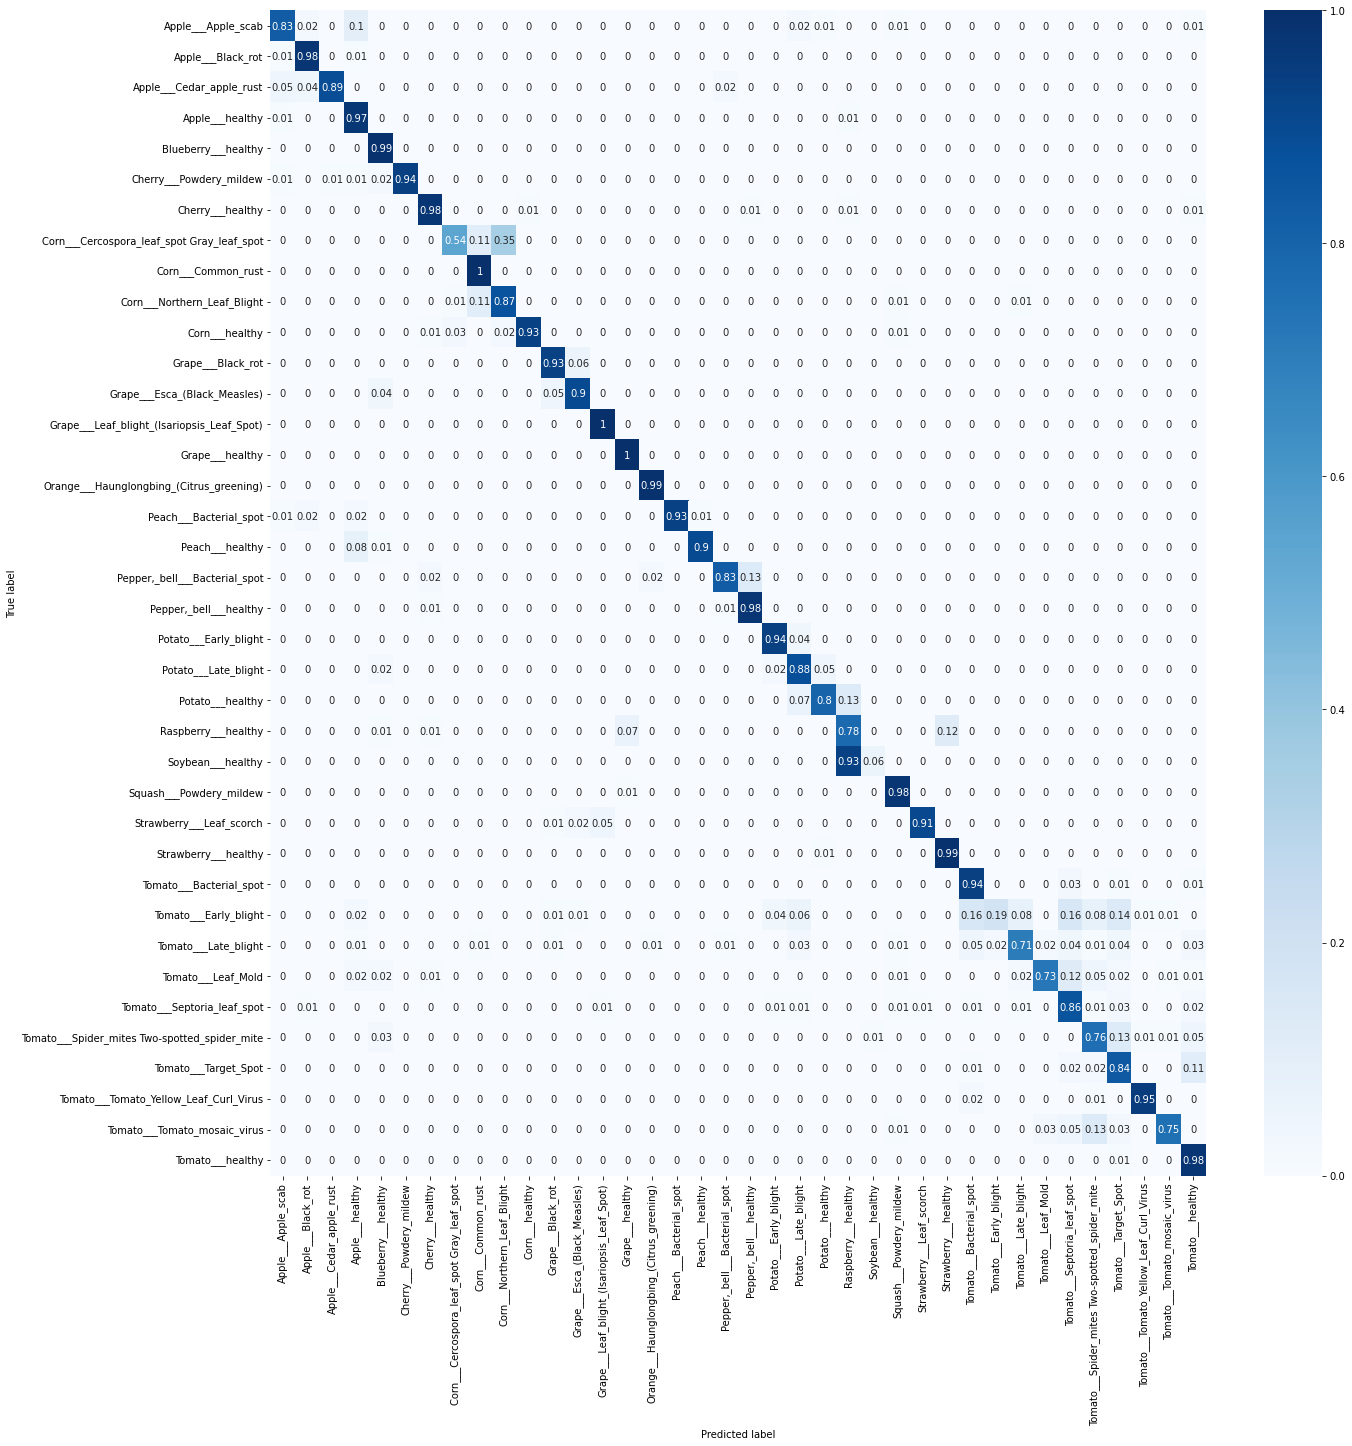

In [ ]:
matrix_confusion=confusion_matrix(test_generator.classes, y_pred)

true_classes = test_generator.classes # numerico
class_labels = list(test_generator.class_indices.keys())   # caracter

con_mat_norm = np.around(matrix_confusion.astype('float') / matrix_confusion.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = class_labels, 
                     columns = class_labels)

figure = plt.figure(figsize=(20, 20))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

0.9241626115488517

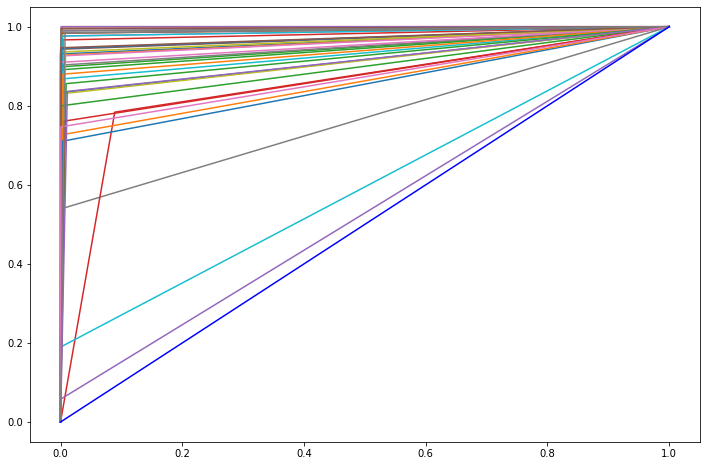

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(class_labels): # all_labels: no of the labels
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling
#test_generator.reset() # resetting generator
#y_pred = model.predict_generator(test_generator, verbose = True)
#y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(test_generator.classes, y_pred)